# Page 261

Baird 反例。

所有的期望方法都不基于仿真。

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 - 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)           #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d.axes3d import Axes3D

# all states: state 0-5 are upper states
STATES = np.arange(0, 7)
# state 6 is lower state
LOWER_STATE = 6
# discount factor
DISCOUNT = 0.99

# each state is represented by a vector of length 8
FEATURE_SIZE = 8
FEATURES = np.zeros((len(STATES), FEATURE_SIZE))
"""
s_1: w_1 w_2 w_3 ...
s_2: ...
"""
for i in range(LOWER_STATE):
    FEATURES[i, i] = 2
    FEATURES[i, 7] = 1
FEATURES[LOWER_STATE, 6] = 1
FEATURES[LOWER_STATE, 7] = 2

# all possible actions
DASHED = 0
SOLID = 1
ACTIONS = [DASHED, SOLID]

# reward is always zero
REWARD = 0

# take @action at @state, return the new state
def step(state, action):
    if action == SOLID:
        return LOWER_STATE
    return np.random.choice(STATES[: LOWER_STATE])

# target policy
def target_policy(state):
    return SOLID

# state distribution for the behavior policy
STATE_DISTRIBUTION = np.ones(len(STATES)) / 7
STATE_DISTRIBUTION_MAT = np.matrix(np.diag(STATE_DISTRIBUTION))
"""
diag 生成对角阵
matrix 把 array 转成 matrix 变量
"""
# projection matrix for minimize MSVE
PROJECTION_MAT = np.matrix(FEATURES) * \
                 np.linalg.pinv(np.matrix(FEATURES.T) * STATE_DISTRIBUTION_MAT * np.matrix(FEATURES)) * \
                 np.matrix(FEATURES.T) * \
                 STATE_DISTRIBUTION_MAT
"""
numpy.linalg 模块包含线性代数的函数
pinv 广义逆
"""

# behavior policy
BEHAVIOR_SOLID_PROBABILITY = 1.0 / 7
def behavior_policy(state):
    if np.random.binomial(1, BEHAVIOR_SOLID_PROBABILITY) == 1:
        return SOLID
    return DASHED

# Semi-gradient off-policy temporal difference
# @state: current state
# @theta: weight for each component of the feature vector
# @alpha: step size
# @return: next state
def semi_gradient_off_policy_TD(state, theta, alpha):
    action = behavior_policy(state)
    next_state = step(state, action)
    # get the importance ratio
    if action == DASHED:
        rho = 0.0
    else:
        rho = 1.0 / BEHAVIOR_SOLID_PROBABILITY
    delta = REWARD + DISCOUNT * np.dot(FEATURES[next_state, :], theta) - \
            np.dot(FEATURES[state, :], theta)
    delta *= rho * alpha
    # derivatives happen to be the same matrix due to the linearity
    theta += FEATURES[state, :] * delta
    return next_state

# Semi-gradient DP
# @theta: weight for each component of the feature vector
# @alpha: step size
def semi_gradient_DP(theta, alpha):
    delta = 0.0
    # go through all the states
    for state in STATES:
        expected_return = 0.0
        # compute bellman error for each state
        for next_state in STATES:
            if next_state == LOWER_STATE:
                expected_return += REWARD + DISCOUNT * np.dot(theta, FEATURES[next_state, :])
        bellmanError = expected_return - np.dot(theta, FEATURES[state, :])
        # accumulate gradients
        delta += bellmanError * FEATURES[state, :]
    # derivatives happen to be the same matrix due to the linearity
    theta += alpha / len(STATES) * delta

# temporal difference with gradient correction
# @state: current state
# @theta: weight of each component of the feature vector
# @weight: auxiliary trace for gradient correction
# @alpha: step size of @theta
# @beta: step size of @weight
def TDC(state, theta, weight, alpha, beta):
    action = behavior_policy(state)
    next_state = step(state, action)
    # get the importance ratio
    if action == DASHED:
        rho = 0.0
    else:
        rho = 1.0 / BEHAVIOR_SOLID_PROBABILITY
    delta = REWARD + DISCOUNT * np.dot(FEATURES[next_state, :], theta) - \
            np.dot(FEATURES[state, :], theta)
    theta += alpha * rho * (delta * FEATURES[state, :] - DISCOUNT * FEATURES[next_state, :] * np.dot(FEATURES[state, :], weight))
    weight += beta * rho * (delta - np.dot(FEATURES[state, :], weight)) * FEATURES[state, :]
    return next_state

# expected temporal difference with gradient correction
# @theta: weight of each component of the feature vector
# @weight: auxiliary trace for gradient correction
# @alpha: step size of @theta
# @beta: step size of @weight
def expected_TDC(theta, weight, alpha, beta):
    for state in STATES:
        # When computing expected update target, if next state is not lower state, importance ratio will be 0,
        # so we can safely ignore this case and assume next state is always lower state
        delta = REWARD + DISCOUNT * np.dot(FEATURES[LOWER_STATE, :], theta) - np.dot(FEATURES[state, :], theta)
        rho = 1 / BEHAVIOR_SOLID_PROBABILITY
        # Under behavior policy, state distribution is uniform, so the probability for each state is 1.0 / len(STATES)
        expected_update_theta = 1.0 / len(STATES) * BEHAVIOR_SOLID_PROBABILITY * rho * (
            delta * FEATURES[state, :] - DISCOUNT * FEATURES[LOWER_STATE, :] * np.dot(weight, FEATURES[state, :]))
        theta += alpha * expected_update_theta
        expected_update_weight = 1.0 / len(STATES) * BEHAVIOR_SOLID_PROBABILITY * rho * (
            delta - np.dot(weight, FEATURES[state, :])) * FEATURES[state, :]
        weight += beta * expected_update_weight

    # if *accumulate* expected update and actually apply update here, then it's synchronous
    # theta += alpha * expectedUpdateTheta
    # weight += beta * expectedUpdateWeight

# interest is 1 for every state
INTEREST = 1

# expected update of ETD
# @theta: weight of each component of the feature vector
# @emphasis: current emphasis
# @alpha: step size of @theta
# @return: expected next emphasis
def expected_emphatic_TD(theta, emphasis, alpha):
    # we perform synchronous update for both theta and emphasis
    expected_update = 0
    expected_next_emphasis = 0.0
    # go through all the states
    for state in STATES:
        # compute rho(t-1)
        if state == LOWER_STATE:
            rho = 1.0 / BEHAVIOR_SOLID_PROBABILITY
        else:
            rho = 0
        # update emphasis
        next_emphasis = DISCOUNT * rho * emphasis + INTEREST
        expected_next_emphasis += next_emphasis
        # When computing expected update target, if next state is not lower state, importance ratio will be 0,
        # so we can safely ignore this case and assume next state is always lower state
        next_state = LOWER_STATE
        delta = REWARD + DISCOUNT * np.dot(FEATURES[next_state, :], theta) - np.dot(FEATURES[state, :], theta)
        expected_update += 1.0 / len(STATES) * BEHAVIOR_SOLID_PROBABILITY * next_emphasis * 1 / BEHAVIOR_SOLID_PROBABILITY * delta * FEATURES[state, :]
    theta += alpha * expected_update
    return expected_next_emphasis / len(STATES)

# compute RMSVE for a value function parameterized by @theta
# true value function is always 0 in this example
def compute_RMSVE(theta):
    return np.sqrt(np.dot(np.power(np.dot(FEATURES, theta), 2), STATE_DISTRIBUTION))

# compute RMSPBE for a value function parameterized by @theta
# true value function is always 0 in this example
def compute_RMSPBE(theta):
    bellman_error = np.zeros(len(STATES))
    for state in STATES:
        for next_state in STATES:
            if next_state == LOWER_STATE:
                bellman_error[state] += REWARD + DISCOUNT * np.dot(theta, FEATURES[next_state, :]) - np.dot(theta, FEATURES[state, :])
    bellman_error = np.dot(np.asarray(PROJECTION_MAT), bellman_error)
    return np.sqrt(np.dot(np.power(bellman_error, 2), STATE_DISTRIBUTION))

figureIndex = 0

In [2]:
# Figure 11.2(left), semi-gradient off-policy TD
def figure_11_2_left():
    # Initialize the theta
    theta = np.ones(FEATURE_SIZE)
    theta[6] = 10

    alpha = 0.01

    steps = 1000
    thetas = np.zeros((FEATURE_SIZE, steps))
    state = np.random.choice(STATES)
    for step in tqdm(range(steps)):
        state = semi_gradient_off_policy_TD(state, theta, alpha)
        thetas[:, step] = theta

    for i in range(FEATURE_SIZE):
        plt.plot(thetas[i, :], label='theta' + str(i + 1))
    plt.xlabel('Steps')
    plt.ylabel('Theta value')
    plt.title('semi-gradient off-policy TD')
    plt.legend()

# Figure 11.2(right), semi-gradient DP
def figure_11_2_right():
    # Initialize the theta
    theta = np.ones(FEATURE_SIZE)
    theta[6] = 10

    alpha = 0.01

    sweeps = 1000
    thetas = np.zeros((FEATURE_SIZE, sweeps))
    for sweep in tqdm(range(sweeps)):
        semi_gradient_DP(theta, alpha)
        thetas[:, sweep] = theta

    for i in range(FEATURE_SIZE):
        plt.plot(thetas[i, :], label='theta' + str(i + 1))
    plt.xlabel('Sweeps')
    plt.ylabel('Theta value')
    plt.title('semi-gradient DP')
    plt.legend()

def figure_11_2():
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    figure_11_2_left()
    plt.subplot(2, 1, 2)
    figure_11_2_right()

    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 16438.90it/s]


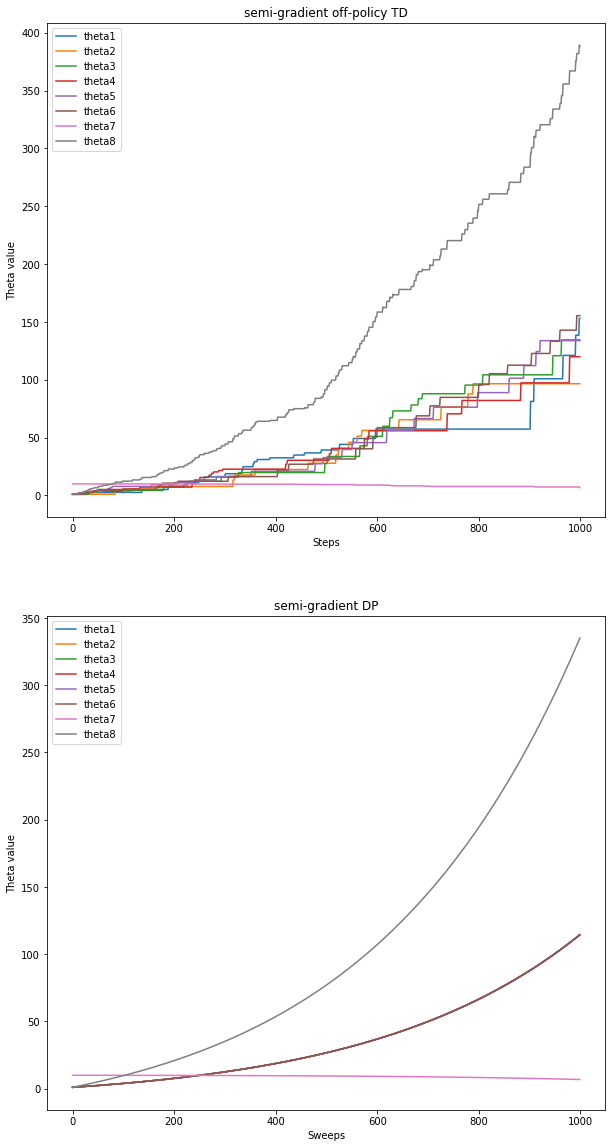

In [3]:
figure_11_2()

In [4]:
# Figure 11.6(left), temporal difference with gradient correction
def figure_11_5_left():
    # Initialize the theta
    theta = np.ones(FEATURE_SIZE)
    theta[6] = 10
    weight = np.zeros(FEATURE_SIZE)

    alpha = 0.005
    beta = 0.05

    steps = 1000
    thetas = np.zeros((FEATURE_SIZE, steps))
    RMSVE = np.zeros(steps)
    RMSPBE = np.zeros(steps)
    state = np.random.choice(STATES)
    for step in tqdm(range(steps)):
        state = TDC(state, theta, weight, alpha, beta)
        thetas[:, step] = theta
        RMSVE[step] = compute_RMSVE(theta)
        RMSPBE[step] = compute_RMSPBE(theta)

    for i in range(FEATURE_SIZE):
        plt.plot(thetas[i, :], label='theta' + str(i + 1))
    plt.plot(RMSVE, label='RMSVE')
    plt.plot(RMSPBE, label='RMSPBE')
    plt.xlabel('Steps')
    plt.title('TDC')
    plt.legend()

# Figure 11.6(right), expected temporal difference with gradient correction
def figure_11_5_right():
    # Initialize the theta
    theta = np.ones(FEATURE_SIZE)
    theta[6] = 10
    weight = np.zeros(FEATURE_SIZE)

    alpha = 0.005
    beta = 0.05

    sweeps = 1000
    thetas = np.zeros((FEATURE_SIZE, sweeps))
    RMSVE = np.zeros(sweeps)
    RMSPBE = np.zeros(sweeps)
    for sweep in tqdm(range(sweeps)):
        expected_TDC(theta, weight, alpha, beta)
        thetas[:, sweep] = theta
        RMSVE[sweep] = compute_RMSVE(theta)
        RMSPBE[sweep] = compute_RMSPBE(theta)

    for i in range(FEATURE_SIZE):
        plt.plot(thetas[i, :], label='theta' + str(i + 1))
    plt.plot(RMSVE, label='RMSVE')
    plt.plot(RMSPBE, label='RMSPBE')
    plt.xlabel('Sweeps')
    plt.title('Expected TDC')
    plt.legend()

def figure_11_5():
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    figure_11_5_left()
    plt.subplot(2, 1, 2)
    figure_11_5_right()

    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 6076.60it/s]


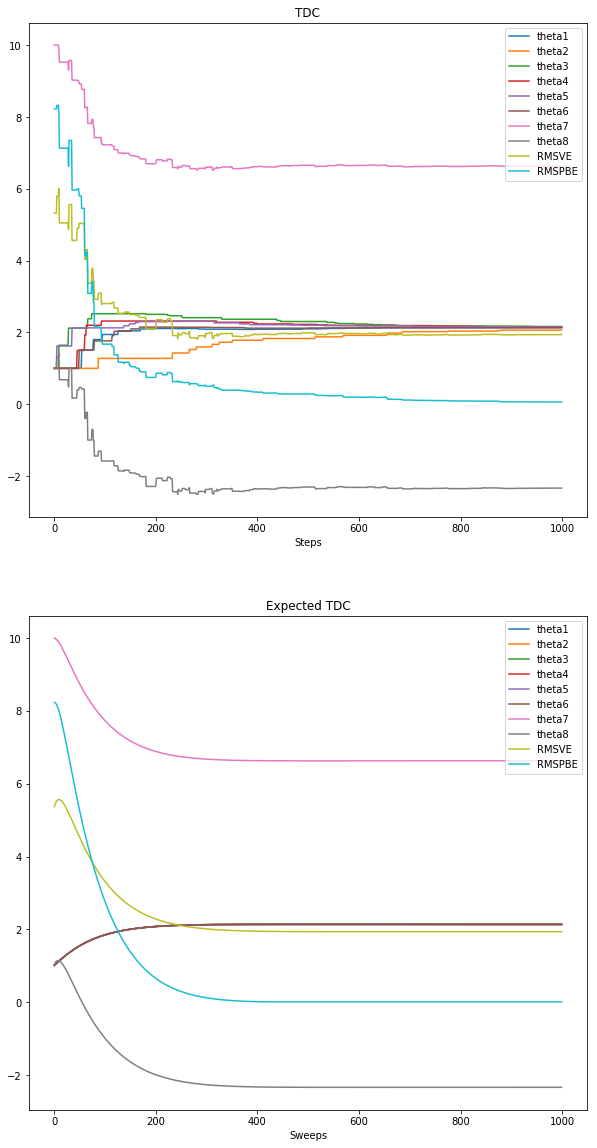

In [5]:
figure_11_5()

In [6]:
# Figure 11.6, expected ETD
def figure_11_6():
    # Initialize the theta
    theta = np.ones(FEATURE_SIZE)
    theta[6] = 10

    alpha = 0.03

    sweeps = 1000
    thetas = np.zeros((FEATURE_SIZE, sweeps))
    RMSVE = np.zeros(sweeps)
    emphasis = 0.0
    for sweep in tqdm(range(sweeps)):
        emphasis = expected_emphatic_TD(theta, emphasis, alpha)
        thetas[:, sweep] = theta
        RMSVE[sweep] = compute_RMSVE(theta)

    for i in range(FEATURE_SIZE):
        plt.plot(thetas[i, :], label='theta' + str(i + 1))
    plt.plot(RMSVE, label='RMSVE')
    plt.xlabel('Sweeps')
    plt.title('emphatic TD')
    plt.legend()

    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 15184.98it/s]


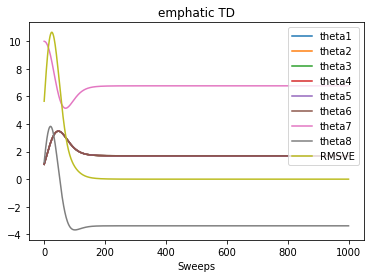

In [7]:
figure_11_6()